# Introduction

This Jupyter notebook validates the Python code used in Supporting Materials 1.

In [25]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from mpmath import mp
%run -i ./Code/graphics.py
"""
Set the number of digits of precision for multiprecision floating-point
operations in the global environment.
"""
mp.dps = 200
"""
Indicate when this code cell was last executed.
"""
from datetime import datetime
print("Time stamp:", datetime.now())

Time stamp: 2020-04-06 13:56:33.153784


# High-level validation

## Tests of solvers

The finite-population model is identical to the infinite-population model when the threshold relative frequency is zero. That is, with the `threshold` parameter set to zero, classes `Solver` and `PoorSolver` both implement the Euler forward method of solving for frequencies at future times, given initial frequencies. Identically initialized instances of the two classes should generate identical solutions. Furthermore, the solutions should be close to those generated by the Runge-Kutta 4(5) method.

**Infinite-population results are identical for `Solver` and `PoorSolver`.**

In the following code cell, instances of `Solver` and `PoorSolver` are initialized identically, with the `threshold` parameter set to zero. Each of the instances is used to solve for end-of-year frequencies in the ensuing 1000 years. The output of the cell indicates whether or not the corresponding solutions of the two solvers are all identical.

In [26]:
%%time
%run -i ./Code/utilities.py
%run -i ./Code/parameters.py
%run -i ./Code/solver.py

def infinite_setup(params, log_steps_per_year=7):
    """
    Returns identically initialized solvers with threshold 0.
    """    
    W = params.W.astype(float)
    initial_freqs = params.initial_freqs().astype(float)
    threshold = 0.0
    args = (W, initial_freqs, log_steps_per_year, threshold)
    return Solver(*args), PoorSolver(*args)

params = Parameters(b_max=0.2, gamma='1e-3')
good_solver, poor_solver = infinite_setup(params)
good_solver(n_years=1000)
poor_solver(n_years=1000)

print('All solutions equal:', np.array_equal(good_solver, poor_solver))

All solutions equal: True
CPU times: user 1min 3s, sys: 2.56 s, total: 1min 5s
Wall time: 19.7 s


**All calculated frequencies are positive.**

In [27]:
print('All solutions positive:', (good_solver[:] > 0).all())

All solutions positive: True


**Results are similar for Euler and Runge-Kutta 4(5) methods.**

Now compare the solutions that we have obtained by the Euler forward method to those produced by the Runge-Kutta 4(5) method, and verify that there is little difference in results.

In [32]:
%%time
"""
We use a library routine for solving the initial value problem.
"""
from scipy.integrate import solve_ivp


def rk45(params, max_year, max_step):
    """
    Returns solutions obtained using the Runge-Kutta 4(5) method.
    
    Normalized solutions at times 0, 1, ..., `max_year` are returned,
    with the solutions for year 0 equal to `params.initial_freqs()`. 
    
    The derivative operator is `params.W`. The solver takes no step
    in time greater than `max_step`.
    """
    # Define a function for calculation of the derivative. It will
    # be called with the time as the first parameter, even though the
    # derivative does not depend on the time.
    W = params.W.astype(float)
    derivative = lambda t, s: W @ s
    #
    # Scale the initial frequencies by an integer power of 2 to avoid
    # over(under)flow in derivative calculations.
    init = params.initial_freqs().astype(float)
    bias_exponents(init, 512)
    #
    # The initial-value-problem solver must be given the times at
    # which to produce solutions.
    times = linspace(0.0, max_year, max_year + 1)
    interval = (times[0], times[-1] + max_step)
    result = solve_ivp(derivative, interval, init, method='RK45',
                       t_eval=times, max_step=max_step, rtol=1e-13,
                       atol=1e-11)
    print(result.message)
    #
    # Transpose the solutions (generated by a FORTRAN routine) to
    # make rows correspond to times. Then normalize the solutions,
    # using `fsum()` to calculate sums accurately.
    solutions = result.y.T
    for i in range(len(solutions)):
        solutions[i] /= fsum(solutions[i])
    return solutions

euler = good_solver
rk_solutions = rk45(params, euler.n_solutions - 1, euler.step_size)

The solver successfully reached the end of the integration interval.
CPU times: user 3min 44s, sys: 9.45 s, total: 3min 53s
Wall time: 1min 6s


<IPython.core.display.Javascript object>


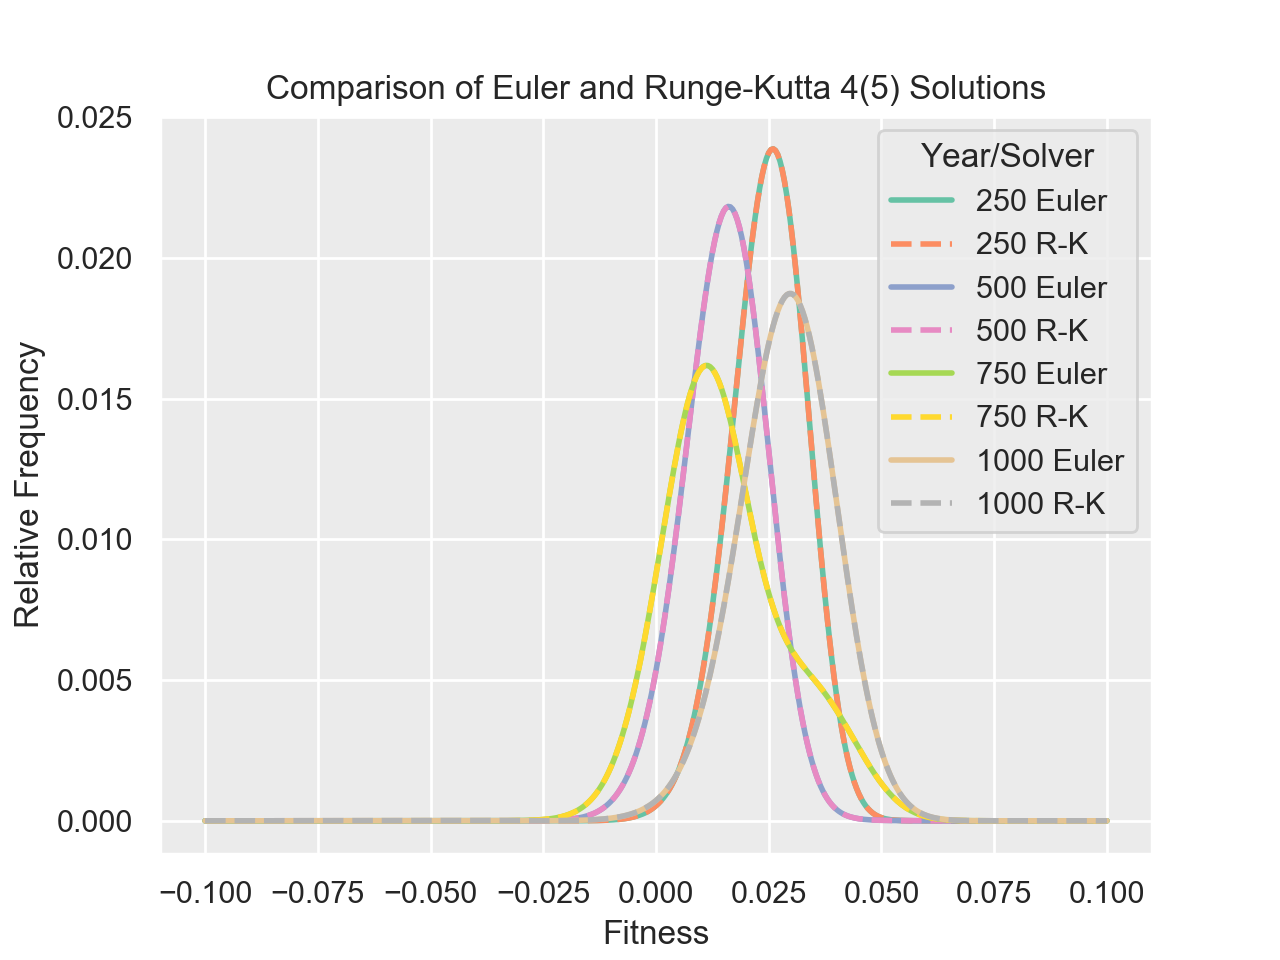

In [28]:
def plot_euler_rk(euler, rk, years):
    """
    Plot `euler` and `rk` solutions for given `years`.
    """
    n_colors = len(years)
    sns.set_palette(sns.color_palette("Set2", n_colors))
    fig, ax = plt.subplots()
    ax.set_title('Comparison of Euler and Runge-Kutta 4(5) Solutions')
    ax.set_xlabel('Fitness')
    ax.set_ylabel('Relative Frequency')
    #
    for i in years:
        ax.plot(params.m, euler[i], label='{:d} Euler'.format(i)) 
        ax.plot(params.m, rk[i], ls='--',  label='{:d} R-K'.format(i))
    ax.legend(title='Year/Solver', loc='best')

plot_euler_rk(good_solver, rk_solutions, [250, 500, 750, 1000])

<IPython.core.display.Javascript object>


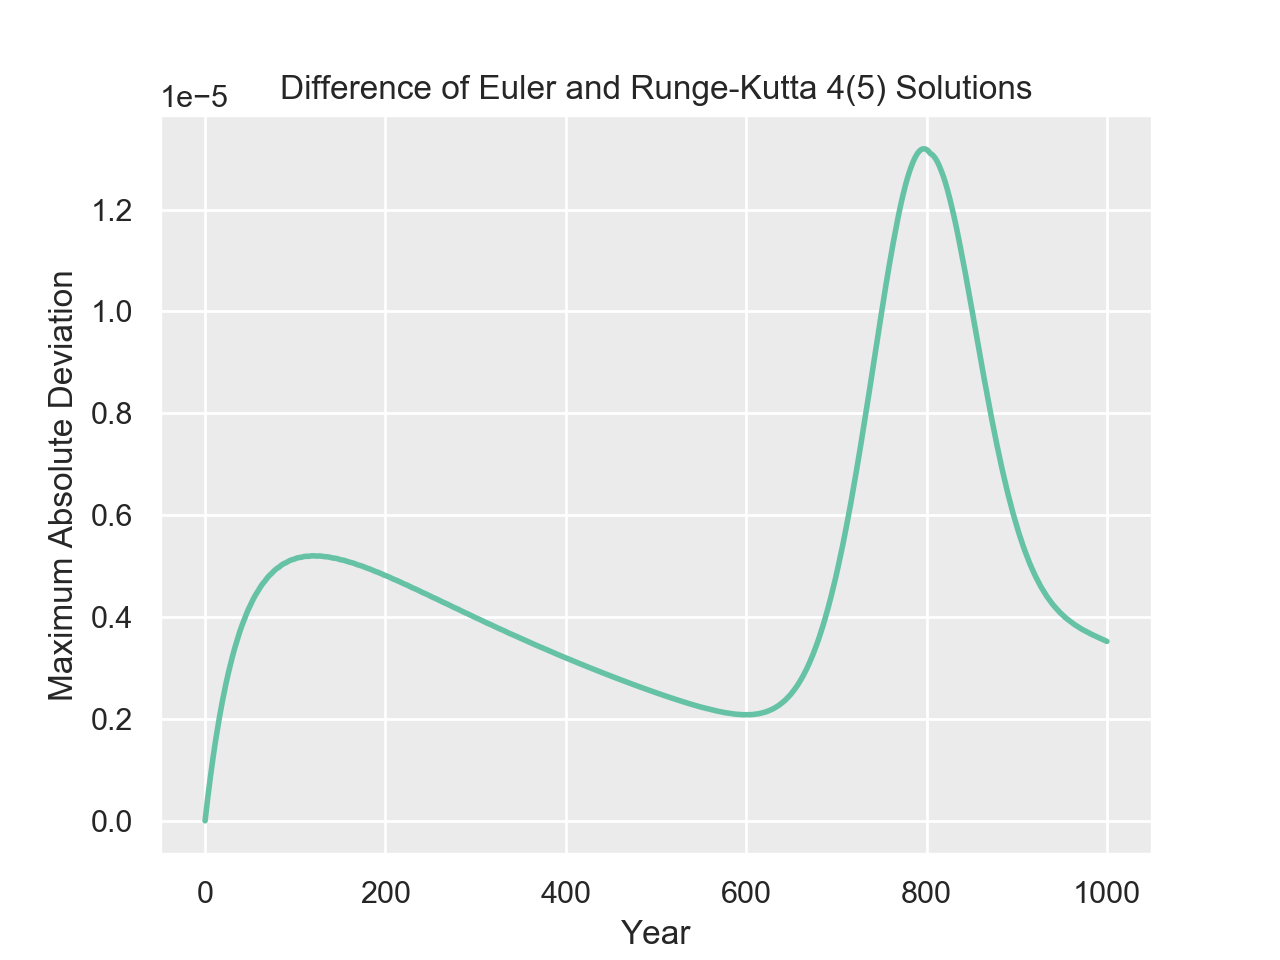

In [44]:
def plot_mad(euler, rk_solutions):
    errs = [np.max(np.abs(s - rk))
                for s, rk in zip(euler, rk_solutions)]
    fig, ax = plt.subplots()
    ax.plot(errs)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xlabel('Year')
    ax.set_ylabel('Maximum Absolute Deviation')
    t = 'Differences of Euler and Runge-Kutta 4(5) Solutions'
    ax.set_title(t)

plot_mad(euler, rk_solutions)

**Convergence to equilibrium**

Now verify that the calculated solutions converge to the equilibrium distribution.

In [4]:
%%time
%run -i ./Code/eigen.py

"""
Use the power method to find the equilibrium distribution `v`.
"""
v, v_error = power_method(good_solver.W)
v /= fsum(v)
#
# Repeatedly run the solver, halting when the error...
s = bias_exponents(np.array(good_solver.s), 503)
s_error, e_value = eigen_error(good_solver.W, good_solver.s)
last_error = np.inf
while s_error < last_error:
    last_error = s_error
    good_solver(5000)
    s = bias_exponents(np.array(good_solver.s), 503)
    s_error, e_value = eigen_error(good_solver.W, s)
    
print('Error for equilibrium v:', v_error)
print('Error for solution s   :', s_error)

Error for equilibrium v: 4.105655810923064e-15
Error for solution s   : 1.709961420392483e-14
CPU times: user 7min 17s, sys: 12.8 s, total: 7min 30s
Wall time: 2min


In [5]:
mean = float(mean_var(good_solver.s, params.m)[0])
mean, e_value

(0.027001740908475336, 0.02700174090847534)

In [6]:
good_solver.n_solutions

16001

<IPython.core.display.Javascript object>


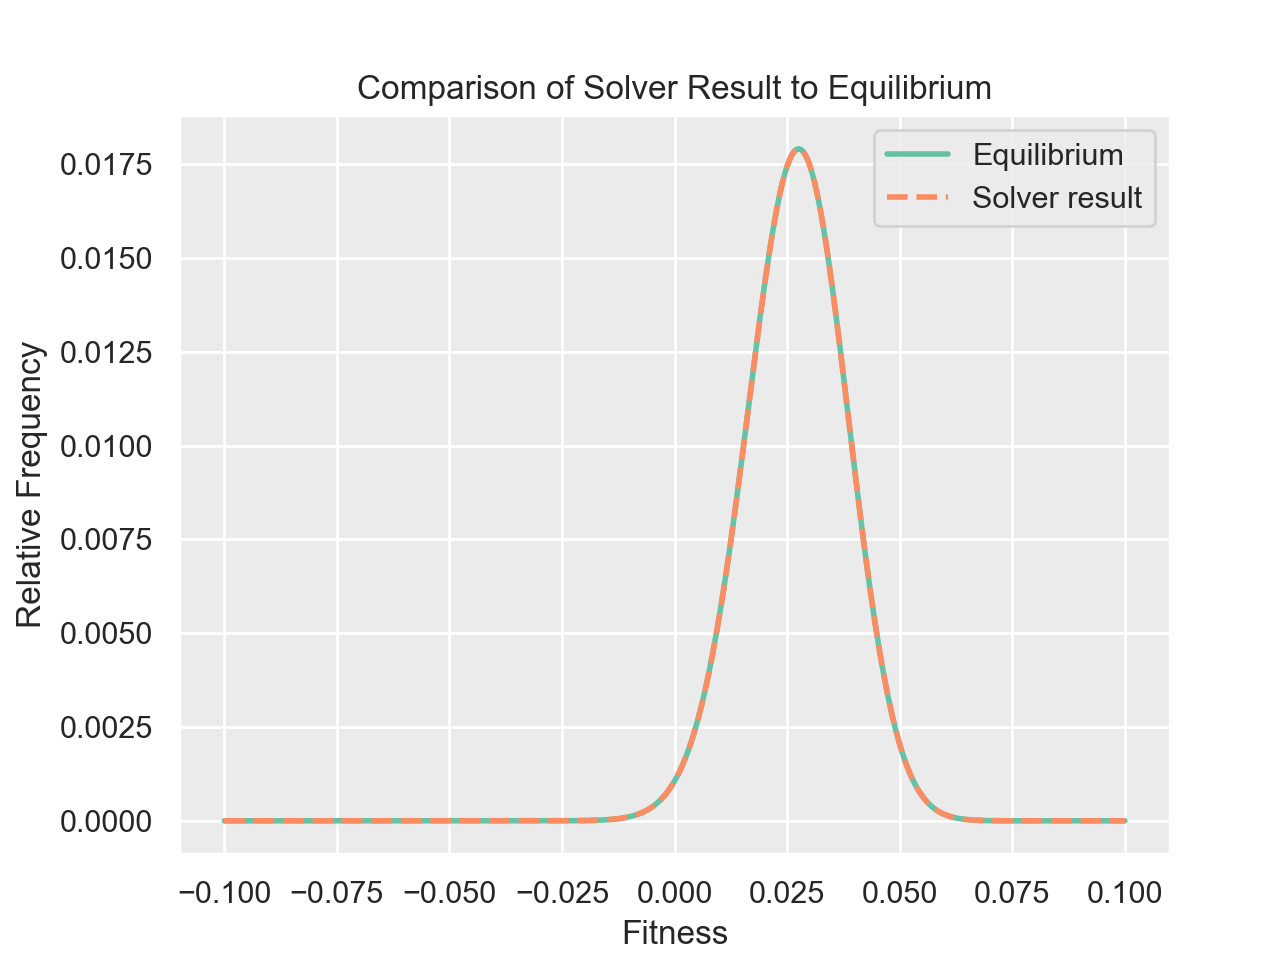

In [11]:
fig, ax = plt.subplots()
ax.plot(params.m, v, label='Equilibrium')
ax.plot(params.m, good_solver[-1], label='Solver result', ls='--')
ax.set_xlabel('Fitness')
ax.set_ylabel('Relative Frequency')
ax.set_title('Comparison of Solver Result to Equilibrium')
ax.legend()
fig.subplots_adjust(left=0.14, right=0.914);

# Thresholding stuff

In [ ]:
threshold = 3.0

In [ ]:
a = np.arange(401.0)
a = np.minimum(a, a[::-1])

trim(a, threshold), a[:10], a[-10:]

In [ ]:
a = np.arange(401.0)
a = np.minimum(a, a[::-1])

alt_trim(a, threshold), a[:10], a[-10:]

In [ ]:
%timeit trim(a, threshold)

In [ ]:
%timeit alt_trim(a, threshold)

In [ ]:
a,p = math.frexp(mp.mpf('123.45'))
type(a), type(p)

In [ ]:
b=convert(a, mp.mpf)
b

In [ ]:
relative_error(b*0.5,a)

In [ ]:
b[0,0] = 1
b

In [ ]:
c=relative_error(b.astype(float)*0.5,a)
#np.abs(c, out=c)
np.max(abs(c))

In [ ]:
abs(-np.inf)

In [ ]:
mp_float(a)